# Imports

In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import catboost as cb

# turn off warnings 
import warnings
warnings.filterwarnings("ignore")

# Functions

In [2]:
def detect_outlier(df, col):
    Q1= df[col].quantile(0.25)
    Q3= df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_index = df.index[ (df[col] < lower_bound) | (df[col] > upper_bound)]
    lower_outliers_index = df.index[ (df[col] < lower_bound)]
    upper_outliers_index = df.index[ (df[col] > upper_bound)]
    
    return outliers_index, lower_outliers_index, upper_outliers_index


def remove_outlier(df , ls):
    ls = sorted(set(ls))
    clean_df= df.drop(ls)
    
    return clean_df

# Raw Data

In [3]:
raw_data = pd.read_csv('newyork_housing.csv')
raw_data.shape

(75630, 1507)

# Data Prep

In [4]:
# getting rid of columns that contain photos
raw_data = raw_data[raw_data.columns.drop(list(raw_data.filter(regex='photos')))]

# getting rid of columns that priceHistory
raw_data = raw_data[raw_data.columns.drop(list(raw_data.filter(regex='priceHistory')))]

# getting rid of columns >> accessibilityFeatures : It's all NULL 
raw_data = raw_data[raw_data.columns.drop(list(raw_data.filter(regex='accessibilityFeatures')))]


# drop NULL values for on market date : we need to know which ones have a date 
raw_data = raw_data.dropna(subset = ['resoFactsStats/onMarketDate'])

# Only keep sold or recently sold properties 
raw_data = raw_data[(raw_data['homeStatus'] == 'SOLD') | (raw_data['homeStatus'] == 'RECENTLY_SOLD')]

#To clean lot size and unify units: replace comma, extract only numbers from col
raw_data['resoFactsStats/lotSize']= raw_data['resoFactsStats/lotSize'].str.replace(',','')
#split by space
raw_data[['lotsize','unit']] = raw_data["resoFactsStats/lotSize"].str.split(" ", 1, expand=True)
#convert string to float
raw_data['lotsize']=raw_data['lotsize'].astype(float)
# convert acre to sqft
raw_data['lot_size_sqf'] = raw_data['lotsize'].apply(lambda x: x * 43560 if x < 100 else x)


#replace comma, extract only numbers from col , and replace Nan with 0 for hoa
raw_data['resoFactsStats/associationFee']= raw_data['resoFactsStats/associationFee'].str.replace(',','')
raw_data['resoFactsStats/associationFee']= raw_data['resoFactsStats/associationFee'].str.extract('(\d+)')
raw_data['hoa']=raw_data['resoFactsStats/associationFee'].fillna(0)


# Convert the weird data format and only keep properties after 2020-05 based on their distribution plot
raw_data['y-m'] =raw_data['resoFactsStats/onMarketDate'].apply(lambda d: datetime.datetime.fromtimestamp(int(d)/1000).strftime('%Y-%m'))
#raw_data['y-m'].value_counts().sort_index(ascending = True).plot()#raw_data['y-m'].value_counts().sort_index(ascending = True).plot()
#raw_data['y-m'].value_counts().sort_index(ascending = False)

#replace NaN with 0 
raw_data['resoFactsStats/hasFireplace'].fillna(0, inplace = True)

#replace NaN first with '0', then create another column that is binary and shows if a property have basement or not 
raw_data['resoFactsStats/basement'].fillna('0', inplace = True)
raw_data['basement'] = raw_data['resoFactsStats/basement'].apply(lambda x: 0 if x == 'None' or x== '0' else 1)


# convert to rigth data types
raw_data=raw_data.astype({'hoa': 'float'})
raw_data=raw_data.astype({'resoFactsStats/hasFireplace': 'float'})

## Extracting timefarme with the highest ferquency
df= raw_data[raw_data['y-m']>='2020-05']


want_cols= ['bathrooms', 
            'bedrooms', 
            'yearBuilt', 
            'propertyTaxRate',
            'livingArea',
            'lot_size_sqf',
            'schools/0/rating',
            'hoa',
            'resoFactsStats/garageSpaces',
            'resoFactsStats/hasFireplace',
            'basement',
            'latitude',
            'longitude',
            'price'
            ]

df = df[want_cols]
df.rename({
            #'resoFactsStats/hasGarage' : 'hasGarage', garage spaces have the same impact, maybe even better
            'resoFactsStats/garageSpaces' : 'garageSpaces',
            'resoFactsStats/hasFireplace' : 'hasFireplace',
            'propertyTaxRate' : 'propTax',
            'schools/0/rating': 'schlRnk',
              }, axis=1, inplace=True)

# Removing outliers

In [5]:
# take out price outliers
outliers_index, lower_index, upper_index = detect_outlier(df, 'price')
#remove lower bound
clean_df= remove_outlier(df, lower_index.tolist())
# remove prices over 2M
clean_df = clean_df[clean_df['price'] <= 2000000]

#remove outlier of garageSpaces
clean_df = clean_df[clean_df['garageSpaces'] <= 6]

#take out lot_sie_sqf outlier out
clean_df=clean_df[clean_df['lot_size_sqf']<=10000]

#take out outlier
clean_df=clean_df[clean_df['bedrooms']<10]

# eliminate hoa outliers
clean_df= clean_df[clean_df['hoa']<=2000]

ValueError: Could not interpret value `basement_` for parameter `x`

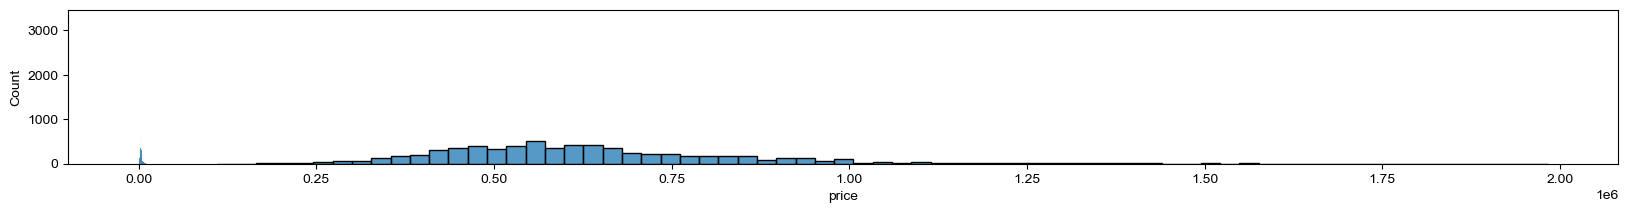

In [6]:
## Plots that help reviewing data


fig, ax =plt.subplots(figsize=(20,2))
sn.histplot(x = clean_df['price'] )

# right skewed 
sn.histplot(clean_df[clean_df['lot_size_sqf']<10000].lot_size_sqf)

# right skewed
sn.histplot(clean_df['latitude'])

# right skewed
sn.histplot(clean_df['longitude'])

# right skewed
sn.histplot(clean_df['bathrooms'])

# right skewed
sn.set(rc={"figure.figsize":(6, 4)})
sn.histplot(clean_df['bedrooms'])

sn.scatterplot(x= 'basement_',
                    y="bathrooms",
                    data= clean_df)

# meh
sn.set(rc={"figure.figsize":(6, 4)})
sn.histplot(clean_df['yearBuilt'])

# meh
sn.histplot(clean_df['propTax'])

# good
sn.histplot(clean_df['schlRnk'])

# right skewed >> better to keep under 1000 or 2000; or give them the max of hoa we want to keep: so we don't drop too much
sn.histplot(clean_df['hoa'])

# right skewed
sn.histplot(clean_df['garageSpaces'])

# right skewed
sn.histplot(clean_df['hasFireplace'])

# good
sn.histplot(clean_df['basement'])

# LivingArea vs. Price
sn.scatterplot(x= 'livingArea',
                    y="price",
                    data= clean_df)

In [ ]:
import matplotlib.pyplot as plt
# Define the number of rows and columns you want
sn.set(rc={"figure.figsize":(16, 20)})
#plt.figure(figsize=(10,20))
n_rows=17
n_cols=1
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

for i, column in enumerate(clean_df.columns):
    sn.histplot(df[column],ax=axes[i])

In [ ]:
sn.pairplot(clean_df)

In [ ]:
for i in clean_df.columns:
    print(i,' NULL %= ', (clean_df[i].isnull().sum() * 100) / 6711)

# X and y

In [7]:
#clean_df.head()
X = clean_df.iloc[:,:-1]
y = clean_df['price']

# train set and remaining set:
X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size = 0.2, random_state=5)

# Splitting remaining set to test set and validation set(houdout)
X_test, X_valid, y_test, y_valid = train_test_split(X_remain, y_remain, test_size = 0.5, random_state=5)

y.shape, X.shape, X_train.shape, X_test.shape, X_valid.shape

((6711,), (6711, 13), (5368, 13), (671, 13), (672, 13))

## Catboost Model

In [8]:
model_c = cb.CatBoostRegressor(loss_function='RMSE') #try R2 as well

model_c.fit(X_train, y_train, plot= True, eval_set=(X_valid, y_valid), verbose = False )
#epochs maybe 200


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
#cv_16_results = cross_val_score(model_c, X_train, y_train, cv=16, verbose= True)

In [ ]:
cv_16_results

In [9]:
pred_c = model_c.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred_c)))
r2 = r2_score(y_test, pred_c)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 92593.91
R2: 0.84


In [ ]:
ax = sn.scatterplot(x= pred_c, y= y_test, alpha = .4, 
              color = 'Black')
ax.set(xlabel='predicted', ylabel='actual')
plt.savefig('pred.png', bbox_inches='tight')
plt.show()

In [ ]:
sn.regplot(x= pred_c, y= y_test)

In [ ]:
feature_importance = model_c.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [10]:
import shap

In [11]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model_c)
# Calculate Shap values
shap_values = explainer.shap_values(X_train)

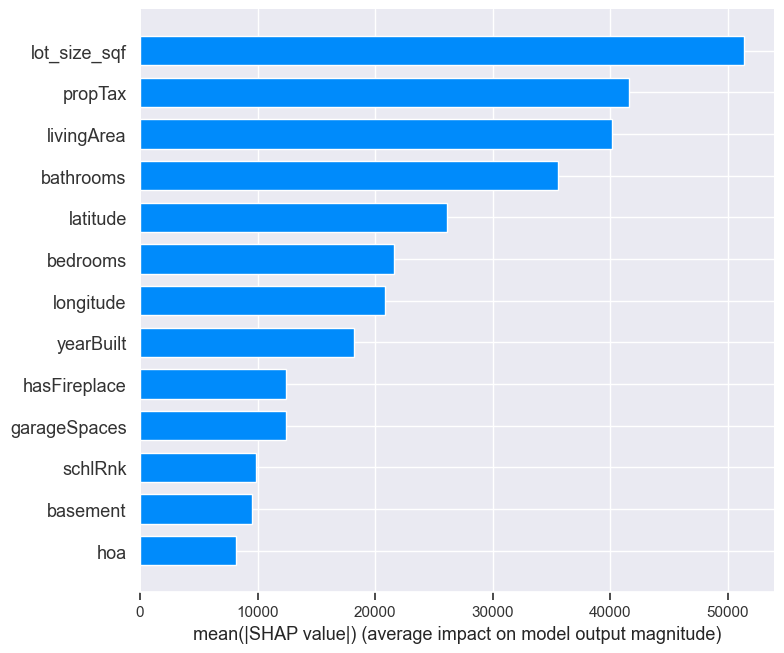

In [12]:
features = X.columns
shap.summary_plot(shap_values, X_train, feature_names=features, plot_type="bar", )

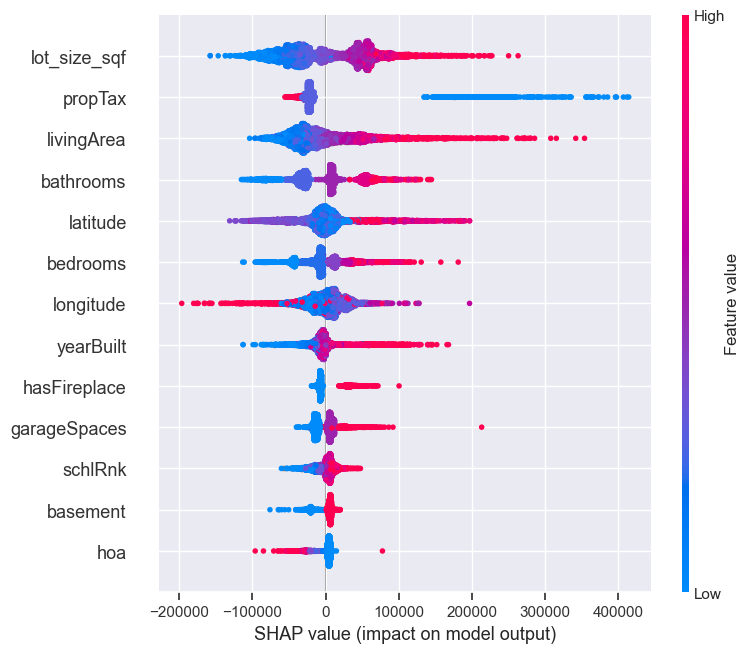

In [13]:
shap.summary_plot(shap_values, X_train, feature_names=features)

# Save the model

In [ ]:
import pickle
  
filename = 'finalized_model.sav'
pickle.dump(model_c, open(filename, 'wb'))

In [ ]:
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

## Evaluation Metrics for Regression
 * MAE:Mean Absolute Error
 * MSE : Mean Squared Error 
 * RMSE : Root Mean Squared error
 * R2 score: Coefficient of determination , Goodness of fit
 * Adjusted R2 score
        

# Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model3 = RandomForestRegressor(n_estimators= 500, random_state = 5)
model3.fit(X_train2, y_train2)
pred3= model3.predict(X_test2) 
rmse3 = (np.sqrt(mean_squared_error(y_test2, pred3)))
r23 = r2_score(y_test2, pred3)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse3))
print('R2: {:.2f}'.format(r23))